In [23]:
import os
import matplotlib.pyplot as plt
import json
import torchmetrics
import torch
import numpy as np

In [49]:
dataset = "fashionmnist"
basepath = f"../lightning_logs/{dataset}"

models = ["deterministic", "pfe", "laplace_posthoc_fix", "laplace_posthoc_pos", "laplace_posthoc_full",
                "laplace_online_fix", "laplace_online_pos", "laplace_online_full",
                "laplace_posthoc_arccos_pos", "laplace_posthoc_arccos_full", "laplace_posthoc_arccos_fix",
                "laplace_online_arccos_pos", "laplace_online_arccos_full", "laplace_online_arccos_fix"]

all_data = {}
for model in models:

    all_data[model] = {}
    for seed in range(1, 6):
        if "laplace_online" in model:
            if "arccos" in model:
                path = os.path.join(basepath, "laplace_online", str(seed), "arccos", model.split("_")[-1])
            else:
                path = os.path.join(basepath, "laplace_online", str(seed), "contrastive", model.split("_")[-1])
        elif "laplace_posthoc" in model:
            if "arccos" in model:
                path = os.path.join(basepath, "laplace_posthoc", str(seed), "arccos", model.split("_")[-1])
            else:
                path = os.path.join(basepath, "laplace_posthoc", str(seed), "contrastive", model.split("_")[-1])
        else:
            path = os.path.join(basepath, model, str(seed))

        path = os.path.join(path, "results/figure_data/test__calibration_curve.json")

        if not os.path.isfile(path):
            print(f"missing => {model} with seed {seed}")
            continue

        with open(path, 'r') as f:
            data = json.load(f)

        for key in data:
            if key in all_data[model]: 
                all_data[model][key] += [data[key]]
            else:
                all_data[model][key] = [data[key]]

missing => deterministic with seed 1
missing => deterministic with seed 2
missing => deterministic with seed 3
missing => deterministic with seed 4
missing => deterministic with seed 5


In [50]:
# load package
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})

In [51]:
import matplotlib
colorname = []
colorid = []
for name, hex in matplotlib.colors.cnames.items():
    colorname.append(name)
    colorid.append(hex)

zippedcolors = list(zip(colorname, colorid))
zippedcolors = sorted(zippedcolors, key=lambda x: x[1])

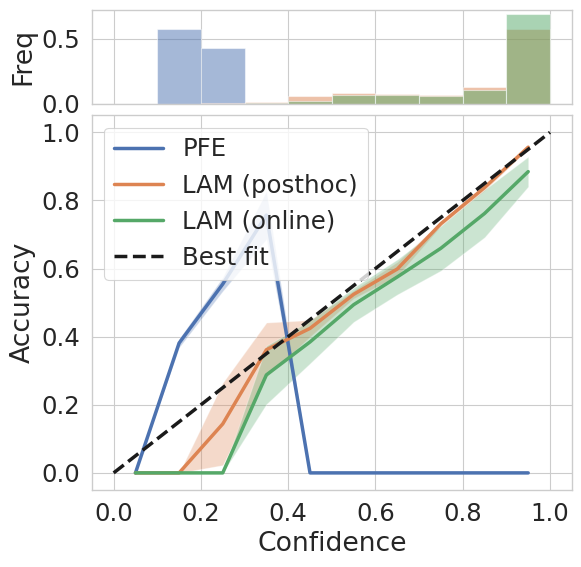

In [54]:
def scatter_hist(ax, ax_histx):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    #ax_histy.tick_params(axis="y", labelleft=False)

    labels = ["PFE", "LAM (posthoc)", "LAM (online)"]

    for mi, model in enumerate(["pfe", "laplace_posthoc_arccos_fix", "laplace_online_arccos_fix"]):
        #if model not in ["pfe", "laplace_posthoc_full", "laplace_online_full"]:
        #    continue
        #print(model)
        if "acc" not in all_data[model]:
            continue

        #if "arc" in model:
        #    continue
        
        for i in range(5):
            acc = all_data[model]["acc"][i]
            confidences = all_data[model]["confidences"][i]
            targets = all_data[model]["targets"][i]
            x = np.linspace(0.05, 0.95, 10).tolist()
            if i == 0:

                val, bin = np.histogram(confidences, bins=10, range=(0.0, 1.0), density=False)
                val = val / np.sum(val)

                ax_histx.bar(x, val, alpha=0.5, width=0.1)

    for mi, model in enumerate(["pfe", "laplace_posthoc_arccos_fix", "laplace_online_arccos_fix"]):
        #if model not in ["pfe", "laplace_posthoc_full", "laplace_online_full"]:
        #    continue
        #print(model)
        if "acc" not in all_data[model]:
            continue

        #if "arc" in model:
        #    continue
        
        x = np.linspace(0.05, 0.95, 10).tolist()

        acc_avg = torch.tensor(all_data[model]["acc"]).mean(dim=0)
        acc_std = torch.tensor(all_data[model]["acc"]).std(dim=0)

        ax.fill_between(x, torch.relu(acc_avg - acc_std), acc_avg + acc_std, alpha=0.3)
        ax.plot(x, acc_avg, label=labels[mi])

    ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), "k--", label="Best fit")
    ax.set_xlabel("Confidence")
    if dataset == "fashionmnist":
        ax.legend()
        ax.set_ylabel("Accuracy")
        ax_histx.set_ylabel("Freq")
    plt.savefig(f"{dataset}_calibration_curve.pdf", bbox_inches='tight')

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 1,  width_ratios=None, height_ratios=(1,4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
#ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ax, ax_histx)
plt.savefig(f"{dataset}_calibration_curve.pdf", bbox_inches='tight')